In [1]:
import sys
sys.path.append('../src')

from recommender import Recommender
rec = Recommender()

/Users/khabith/Files/Github/Recommendation-system/recommender-notebooks/../src/recommender.py:10: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  md = pd.read_csv('../dataset/movies_metadata.csv')


[CONTENT_BASED] Loading existing movies latent feature from disk.
[CONTENT_BASED] DONE!


In [133]:
movie_ids = [862, 8844, 339403, 324852, 335988, 268, 10895, 329, 101, 807, 414, 372058, 1924]
ratings = [5, 3.5, 4, 5, 3.5, 4.5, 5, 2.5, 5, 5, 4.5, 5, 3]
recommendations, raw_recommendations = rec.recommend(movie_ids, ratings, 10, 0.5)

In [140]:
recommendations.head(2)

,title,genres,wr,final_similarity,genres_similarity,cast_similarity,crew_similarity,keyword_similarity,overview_similarity,ranking_metrics,movieId,rating,hybrid
6,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]",7.589360,0.643472,0.634688,1.0,0.998889,0.760827,0.447451,0.672338,49026,3.543703,0.676106
7,Batman Begins,"[Action, Crime, Drama]",7.487556,0.640840,0.584095,1.0,0.998889,0.713761,0.516409,0.667819,272,4.022920,0.722712


## Metrics

In [38]:
def precision_at_k(recommended_ids, relevant_ids, k):
    return len(set(recommended_ids[:k]) & set(relevant_ids)) / k

def recall_at_k(recommended_ids, relevant_ids, k):
    return len(set(recommended_ids[:k]) & set(relevant_ids)) / len(relevant_ids)

def hit_rate_at_k(recommended_ids, relevant_ids, k):
    return int(bool(set(recommended_ids[:k]) & set(relevant_ids)))

def average_precision_at_k(recommended_ids, relevant_ids, k):
    ap = 0.0
    hits = 0
    for i, rec_id in enumerate(recommended_ids[:k], start=1):
        if rec_id in relevant_ids:
            hits += 1
            ap += hits / i
    return ap / min(len(relevant_ids), k) if hits > 0 else 0.0

def ndcg_at_k(recommended_ids, relevant_ids, k):
    dcg = 0.0
    for i, rec_id in enumerate(recommended_ids[:k], start=1):
        if rec_id in relevant_ids:
            dcg += 1.0 / np.log2(i+1)
    idcg = sum(1.0/np.log2(i+1) for i in range(1, min(len(relevant_ids), k)+1))
    return dcg/idcg if idcg>0 else 0.0


## Evaluation loop

In [124]:
import numpy as np
import pandas as pd

# Load ratings and randomly sample 50 users
ratings = pd.read_csv('../dataset/ratings_small.csv')
random_users = np.random.choice(ratings['userId'].unique(), size=100, replace=False)
ratings = ratings[ratings['userId'].isin(random_users)]

# Time-aware leave-one-out split per user
test_idx = ratings.groupby('userId')['timestamp'].idxmax()
test_df = ratings.loc[test_idx]
train_df = ratings.drop(test_idx)

train_items_by_user = train_df.groupby('userId')['movieId'].apply(list).to_dict()
test_items_by_user = test_df.set_index('userId')['movieId'].to_dict()

In [126]:
alphas = [0.0, 0.25, 0.5, 0.75, 1.0]
Ks = [10, 20]
metrics_per_alpha = {alpha: {k: {'precision': [], 'recall': [], 'hr': [], 'map': [], 'ndcg': []} 
                             for k in Ks} for alpha in alphas}

for user_id in train_items_by_user.keys():
    user_train = train_items_by_user[user_id]
    user_test = [test_items_by_user[user_id]] if user_id in test_items_by_user else []
    if not user_test:
        continue

    for alpha in alphas:
        top_n = max(Ks)
        user_ratings = ratings.loc[(ratings['userId'] == user_id) & ratings['movieId'].isin(user_train), 'rating'].values
        recommendations, _ = rec.recommend(user_train, user_ratings,
                                            n_recommendation=top_n, alpha=alpha)
        
        recommended_ids = recommendations['movieId'].tolist()
        
        for K in Ks:
            print(f"{user_id}-{alpha}-{K}")
            recs_k = recommended_ids[:K]
            metrics_per_alpha[alpha][K]['precision'].append(precision_at_k(recs_k, user_test, K))
            metrics_per_alpha[alpha][K]['recall'].append(recall_at_k(recs_k, user_test, K))
            metrics_per_alpha[alpha][K]['hr'].append(hit_rate_at_k(recs_k, user_test, K))
            metrics_per_alpha[alpha][K]['map'].append(average_precision_at_k(recs_k, user_test, K))
            metrics_per_alpha[alpha][K]['ndcg'].append(ndcg_at_k(recs_k, user_test, K))

19-0.0-10
19-0.0-20
19-0.25-10
19-0.25-20
19-0.5-10
19-0.5-20
19-0.75-10
19-0.75-20
19-1.0-10
19-1.0-20
23-0.0-10
23-0.0-20
23-0.25-10
23-0.25-20
23-0.5-10
23-0.5-20
23-0.75-10
23-0.75-20
23-1.0-10
23-1.0-20
25-0.0-10
25-0.0-20
25-0.25-10
25-0.25-20
25-0.5-10
25-0.5-20
25-0.75-10
25-0.75-20
25-1.0-10
25-1.0-20
29-0.0-10
29-0.0-20
29-0.25-10
29-0.25-20
29-0.5-10
29-0.5-20
29-0.75-10
29-0.75-20
29-1.0-10
29-1.0-20
35-0.0-10
35-0.0-20
35-0.25-10
35-0.25-20
35-0.5-10
35-0.5-20
35-0.75-10
35-0.75-20
35-1.0-10
35-1.0-20
39-0.0-10
39-0.0-20
39-0.25-10
39-0.25-20
39-0.5-10
39-0.5-20
39-0.75-10
39-0.75-20
39-1.0-10
39-1.0-20
45-0.0-10
45-0.0-20
45-0.25-10
45-0.25-20
45-0.5-10
45-0.5-20
45-0.75-10
45-0.75-20
45-1.0-10
45-1.0-20
46-0.0-10
46-0.0-20
46-0.25-10
46-0.25-20
46-0.5-10
46-0.5-20
46-0.75-10
46-0.75-20
46-1.0-10
46-1.0-20
53-0.0-10
53-0.0-20
53-0.25-10
53-0.25-20
53-0.5-10
53-0.5-20
53-0.75-10
53-0.75-20
53-1.0-10
53-1.0-20
55-0.0-10
55-0.0-20
55-0.25-10
55-0.25-20
55-0.5-10
55-0.5-20
55

In [128]:
agg_results = {alpha: {k: {m: np.mean(metrics_per_alpha[alpha][k][m]) 
                           for m in metrics_per_alpha[alpha][k]} 
                       for k in Ks} for alpha in alphas}

import pandas as pd
rows = []
for alpha in alphas:
    for K in Ks:
        row = {'alpha': alpha, 'K': K}
        row.update(agg_results[alpha][K])
        rows.append(row)
df_metrics = pd.DataFrame(rows)
df_metrics

,alpha,K,precision,recall,hr,map,ndcg
0,0.00,10,0.0,0.0,0.0,0.0,0.0
1,0.00,20,0.0,0.0,0.0,0.0,0.0
2,0.25,10,0.0,0.0,0.0,0.0,0.0
3,0.25,20,0.0,0.0,0.0,0.0,0.0
4,0.50,10,0.0,0.0,0.0,0.0,0.0
5,0.50,20,0.0,0.0,0.0,0.0,0.0
6,0.75,10,0.0,0.0,0.0,0.0,0.0
7,0.75,20,0.0,0.0,0.0,0.0,0.0
8,1.00,10,0.0,0.0,0.0,0.0,0.0
9,1.00,20,0.0,0.0,0.0,0.0,0.0


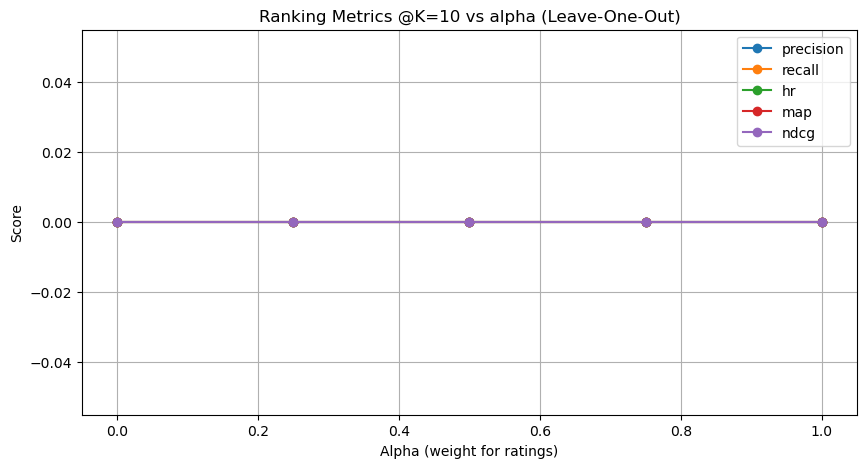

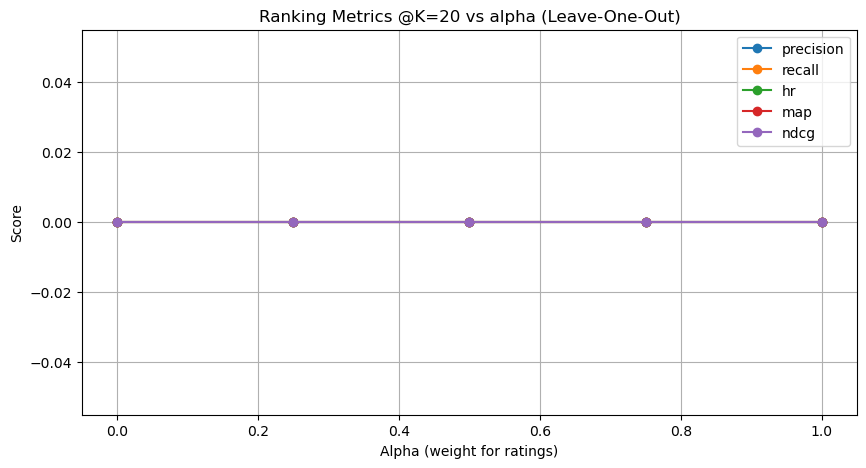

In [130]:
import matplotlib.pyplot as plt

for K in Ks:
    plt.figure(figsize=(10,5))
    df_k = df_metrics[df_metrics['K']==K]
    for metric in ['precision','recall','hr','map','ndcg']:
        plt.plot(df_k['alpha'], df_k[metric], marker='o', label=metric)
    plt.title(f"Ranking Metrics @K={K} vs alpha (Leave-One-Out)")
    plt.xlabel("Alpha (weight for ratings)")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.show()